# Black-Scholes Code

Now that we understand the formula, **we'll create a function in Python to price call and put options** given a specific set of inputs.

## Importing Libraries

For the maths behind the formula we'll use the `scipy` and `numpy` libraries. For generating plots we'll use the `matplotlib` and `seaborn` libraries. And we'll also use `yfinance` library to analyze some real-world data.

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

## Function

The formula for a option's price takes five variables as input: **volatility ($\sigma$), strike price ($K$), current spot price ($S$), time until maturity ($T$) and the risk-free rate ($r$)**. The formulas for a call and a put option are as follow:

$$C = S\Phi(d_1) - e^{-rT}K\Phi (d_2)$$
$$P = e^{-rT}K\Phi (-d_2) - S_t\Phi(-d_1)$$

where:

$$d_1 = \frac{log(\frac{S}{K}) + T(r + \sigma^2/2)}{\sigma \sqrt{T}}$$
$$d_2 = d_1 - \sigma \sqrt{T}$$

For the function $\Phi$, which is a [CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), we'll use the `norm.cdf()` method from the `scipy.stats` library. Besides the five variables used to calculate the option's price, **we'll also include an extra input specifying the type of option: call or put**.

In [9]:
def black_scholes(type, sigma, K, S, T, r):
    """"
    Applies the Black-Scholes Model to calculate the price of a option.
    """

    # Calculates parameters d_1 and d_2 from the Black-Scholes formula
    d_1 = (np.log(S / K) + T * (r + sigma ** 2 / 2)) / (sigma * np.sqrt(T))
    d_2 = d_1 - sigma * np.sqrt(T)

    # Calculates the value of the option based on its type, either "call" or "put"
    if type == "call":

        V = S * norm.cdf(d_1) - np.exp(-r * T) * K * norm.cdf(d_2)

    elif type == "put":

        V = np.exp(-r * T) * K * norm.cdf(-d_2) - S * norm.cdf(-d_1)

    return V

Let's use the function above to calculate the price of a call and a put option for a Walmart stock.

At first, we'll calculate the price for **a call option with a 3-month maturity and a strike price of $60**. Since we're pricing a 3-month maturity call option, **we'll use a [3-month U.S. Treasury Bill yield](https://www.cnbc.com/quotes/US3M)** as our risk-free interest rate. **The volatility is equal to the annualized standard deviation of the stock's logarithmic returns.**

The current stock price, yield of the 3-month Treasury bill and volatility is retrieved using the `yfinance` library.

In [99]:
# Setting parameters
K = 60 # The strike price of this call option is $60
T = 3 # It will take one 3 months to expire

# Retrieves the risk-free interest rate
t_bill_3m = yf.Ticker("^IRX").history()
r = t_bill_3m["Close"].iloc[-1] / 100

# Calculates the underlying stock's volatility
prices = yf.Ticker('WMT').history(start=datetime(2019, 1, 1))['Close']
returns = np.log(prices / prices.shift())
sigma = returns.std() * np.sqrt(252)

# Retrieves the underlying stock's current price
S = prices.iloc[-1]

# Calling the function
C = black_scholes("call", sigma, K, S, T/12, r) # We divide T by 12 because r is annualized

print("-- Black-Scholes Call Option Pricing Model --")
print("Stock: Walmart (WMT)")
print(f"Current Value: ${S: .2f}")
print(f"Strike Price: $ {K}")
print(f"Time to Expiration: {T} months")
print(f"Risk-free Rate:{r*100: .2f}%")
print(f"Option Valued at: ${C: .2f}")

-- Black-Scholes Call Option Pricing Model --
Stock: Walmart (WMT)
Current Value: $ 96.54
Strike Price: $ 60
Time to Expiration: 3 months
Risk-free Rate: 4.10%
Option Valued at: $ 37.15


We can also use the `yfinance` library to get some idea of what the market is pricing this call option.

In [100]:
from datetime import timedelta

wmt = yf.Ticker("WMT")
available_dates = wmt.options

today = datetime.now()
target_date = today + timedelta(days=90) # Approximate 3 months

# Calculate the difference between each available date and the target date
closest_date = min(available_dates, key=lambda d: abs(datetime.strptime(d, "%Y-%m-%d") - target_date))

print(f"Today's Date: {today.strftime('%Y-%m-%d')}")
print(f"Closest available expiration date to 3 months from now: {closest_date}\n")

# Get the option chain for the closest date
option_chain = wmt.option_chain(closest_date)
calls = option_chain.calls

# Find the specific call option with the $60 strike price
call_option = calls[calls['strike'] == K]

print("-- Call Option Current Price --")
print("Stock: Walmart (WMT)")
print(f"Current Value: ${S: .2f}")
print(f"Strike Price: $ {K}")
print(f"Expiration Date: {closest_date}")
print(f"Risk-free Rate:{r*100: .2f}%")
print(f"Option Bid Price: ${call_option['bid'].values[0]: .2f}")
print(f"Option Ask Price: ${call_option['ask'].values[0]: .2f}")

Today's Date: 2025-08-25
Closest available expiration date to 3 months from now: 2025-11-21

-- Call Option Current Price --
Stock: Walmart (WMT)
Current Value: $ 96.54
Strike Price: $ 60
Expiration Date: 2025-11-21
Risk-free Rate: 4.10%
Option Bid Price: $ 37.20
Option Ask Price: $ 37.40


Our Black-Scholes model priced this call option at $37.15, while the current bid price is at $37.20. The **bid price represents the highest price a buyer is willing to accept**, which means that this is the value you would get for selling the option immediately. Our model's value is slightly lower than the current bid price. **This suggests two things: the model's output seems reasonable and that the option might be slightly overvalued.** We could short the call option for $37.20 now and buy it later, because we think it's true value might be $37.15.

Now, we'll try pricing a put option with a 3-month maturity and a strike price of 100. The other parameters we'll remain the same, since they are not specific to a call option.

In [101]:
# Setting Parameters
K = 100 # The strike price of this call option is $60
T = 3 # It will take one 3 months to expire

# Retrieves the risk-free interest rate
t_bill_3m = yf.Ticker("^IRX").history()
r = t_bill_3m["Close"].iloc[-1] / 100

# Calculates the underlying stock's volatility
prices = yf.Ticker('WMT').history(start=datetime(2019, 1, 1))['Close']
returns = np.log(prices / prices.shift())
sigma = returns.std() * np.sqrt(252)

# Retrieves the underlying stock's current price
S = prices.iloc[-1]

# Calling the function
P = black_scholes("put", sigma, K, S, T/12, r) # We divide T by 12 because r is annualized

print("-- Black-Scholes Put Option Pricing Model --")
print("Stock: Walmart (WMT)")
print(f"Current Value: ${S: .2f}")
print(f"Strike Price: ${K: .2f}")
print(f"Time to Expiration: {T: .2f} months")
print(f"Risk-free Rate: {r*100: .2f}%")
print(f"Option Valued at: ${P: .2f}")

-- Black-Scholes Put Option Pricing Model --
Stock: Walmart (WMT)
Current Value: $ 96.51
Strike Price: $ 100.00
Time to Expiration:  3.00 months
Risk-free Rate:  4.10%
Option Valued at: $ 5.63


In [102]:
wmt = yf.Ticker("WMT")
available_dates = wmt.options

today = datetime.now()
target_date = today + timedelta(days=90) # Approximate 3 months

# Calculate the difference between each available date and the target date
closest_date = min(available_dates, key=lambda d: abs(datetime.strptime(d, "%Y-%m-%d") - target_date))

print(f"Today's Date: {today.strftime('%Y-%m-%d')}")
print(f"Closest available expiration date to 3 months from now: {closest_date}\n")

# Get the option chain for the closest date
option_chain = wmt.option_chain(closest_date)
puts = option_chain.puts

# Find the specific put option with the $60 strike price
put_option = puts[puts['strike'] == K]

print("-- Put Option Current Price --")
print("Stock: Walmart (WMT)")
print(f"Current Value: ${S: .2f}")
print(f"Strike Price: $ {K}")
print(f"Expiration Date: {closest_date}")
print(f"Risk-free Rate:{r*100: .2f}%")
print(f"Option Bid Price: ${put_option['bid'].values[0]: .2f}")
print(f"Option Ask Price: ${put_option['ask'].values[0]: .2f}")

Today's Date: 2025-08-25
Closest available expiration date to 3 months from now: 2025-11-21

-- Put Option Current Price --
Stock: Walmart (WMT)
Current Value: $ 96.51
Strike Price: $ 100
Expiration Date: 2025-11-21
Risk-free Rate: 4.10%
Option Bid Price: $ 5.50
Option Ask Price: $ 5.60


Our Black-Scholes model priced this put option at $5.63, while the ask price is at $5.60. Our model's value is slightly higher than the current ask price. The **ask price represents the lowest price a seller is willing to accept**, which means that this is the price you would have to pay to buy the option immediately. Again, **this suggests that the model's output seems reasonable and that the option might be slightly undervalued**. We could buy the put option for $5.60 now, because we think it's true value might be $5.63.

Nevertheless, the return on these operations is extremely small. **This slim discrepancy is most likely due to the approximations from the assumptions of the Black-Scholes model.** The two possibilities of trades presented would probably not result in any profit, considering transaction fees on buying and selling options.

## Prices Heatmap

Another way we can visualize different option prices is by creating a grid with multiple strike prices and times to maturity. For every combination of K and T, we can calculate a call and put option. **With this matrix of values, we plot a heatmap, so the contrast between prices is more evident.**

In [103]:
import pandas as pd

def price_matrix(type, sigma, S, r):

    # Create two arrays of strike prices and months to maturity
    if type == 'call':
        strike_prices = np.arange(S-35, S+10, 5)
    elif type == 'put':
        strike_prices = np.arange(S-5, S+40, 5)
    months = np.arange(1, 13, 1)

    # Initialize empty matrix
    matrix = []

    for K in strike_prices:

        row = []

        for T in months:

            # Calculate option value for each K in strike_prices and T in months
            V = black_scholes(type, sigma, K, S, T/12, r)

            row.append(V)

        matrix.append(row)

    price_labels = [f'${price}' for price in np.round(strike_prices).astype(int)]

    df = pd.DataFrame(matrix, index=price_labels, columns=months)

    return df

call_df = price_matrix('call', sigma, S, r)
put_df = price_matrix('put', sigma, S, r)

Now, we plot the heatmap using the `seaborn` library.

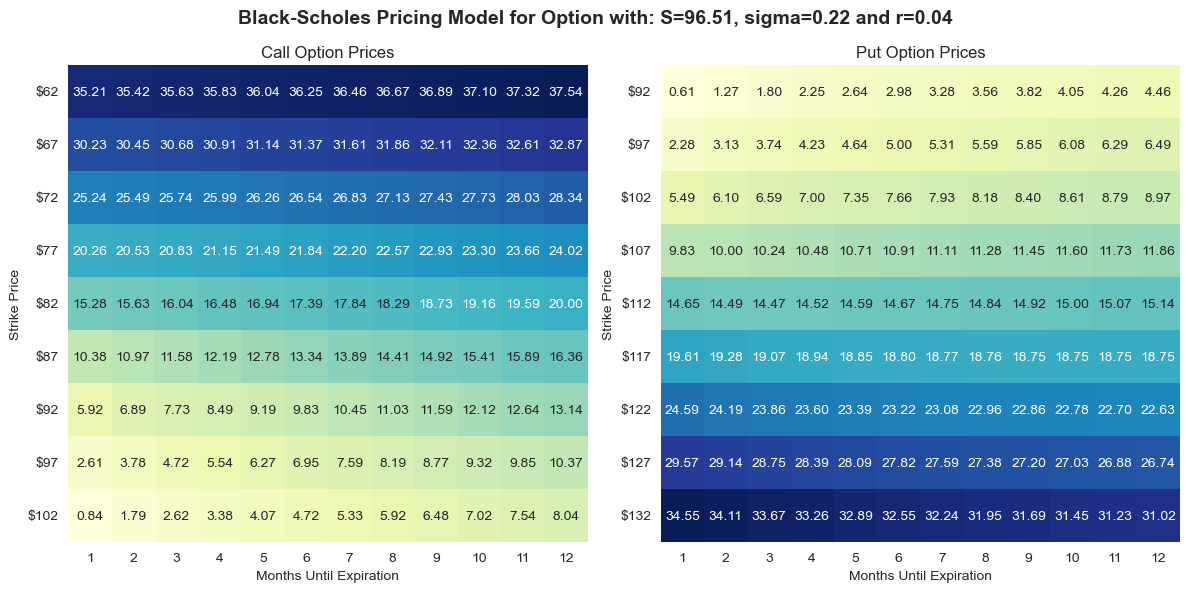

In [104]:
# Setting heatmap parameters
heatmap_params = {
    'annot': True, 
    'fmt': '.2f', 
    'cmap': "YlGnBu", 
    'cbar': False
}

dfs = {
    'Call Option Prices': call_df,
    'Put Option Prices': put_df
}

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for ax, (title, data) in zip(axs, dfs.items()):
    sns.heatmap(data, ax=ax, **heatmap_params)
    ax.set(title=title, 
           xlabel='Months Until Expiration', 
           ylabel='Strike Price')
    ax.tick_params(axis='y', rotation=0)

fig.suptitle(f'Black-Scholes Pricing Model for Option with: S={round(S, 2)}, sigma={round(sigma, 2)} and r={round(r, 2)}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Let's first take a look at the call option prices. **As the strike prices decrease, the call option turns more valuable.** That's because investors would like to buy the stock for cheaper in the future. Now, looking at the x-axis, *the options' prices increase as the months to maturity increase.* If we're expecting the stock to keep increasing in value (because of a drift), the return on buying the option, for a specific strike price, also increases as the time to maturity is further away.

Next, let's analyze the put options' prices. **As the strike prices increase, the put option turns more valuable.** The reason for that is investors are always looking to sell their stocks for a higher value. As for the x-axis, **the price drops as the maturity increases.** If we're expecting the stock to keep increasing in value, the return on selling the stock, for a specific strike price, decreases as the time to maturity is further away.